In [1]:
import PowerSensor as ps
import numpy as np
import cv2 as cv
import time
from IPython.display import clear_output

In [2]:
debug_flag = True

In [3]:
cam = ps.ImageSensor()

unknown color


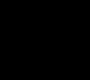

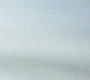

4.88188305513


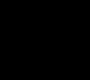

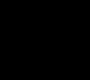

0


IndexError: list index out of range

In [50]:
while True:
    if debug_flag:
        time0 = time.time()
    frame = cam.read_img_ori()
    if debug_flag:
        # ps.CommonFunction.show_img_jupyter(frame)
        # time1 = time.time()
        # fps = 1 / (time1 - time0)
        # print fps
        pass
    roi = frame[170:250, 350:440].copy()
    mask = np.zeros(roi.shape, roi.dtype)
    if debug_flag:
        pass
        # ps.CommonFunction.show_img_jupyter(roi)
    # 给明显的蓝绿红在mask上着色
    blue_pixel = 0
    green_pixel = 0
    red_pixel = 0
    # 0表示蓝，1表示绿，2表示红
    color = -1
    for i in range(roi.shape[0]):
        for j in range(roi.shape[1]):
            # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
            if (roi.item(i, j, 0) - roi.item(i, j, 1) > 50) and (roi.item(i, j, 0) - roi.item(i, j, 2) > 50):
                color = 0
                blue_pixel += 1
                # print('blue')
                # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
                mask[i, j] = [0, 255, 255]
            elif (roi.item(i, j, 1) - roi.item(i, j, 0) > 30) and (roi.item(i, j, 1) - roi.item(i, j, 2) > 30):
                color = 1
                green_pixel += 1
                # print('green')
                # print(roi.item(i, j, 0), roi.item(i, j, 1), roi.item(i, j, 2))
                mask[i, j] = [255, 0, 255]
            elif (roi.item(i, j, 2) - roi.item(i, j, 1) > 30) and (roi.item(i, j, 2) - roi.item(i, j, 0) > 30):
                color = 2
                red_pixel += 1
                # print('red')
                # print(frame.item(i, j, 0), frame.item(i, j, 1), frame.item(i, j, 2))
                mask[i, j] = [255, 255, 0]

            # if (roi.item(i, j, 0) > roi.item(i, j, 1)) and (roi.item(i, j, 0) > roi.item(i, j, 2)) and \
            #     ((roi.item(i, j, 0) - roi.item(i, j, 1) > 50) or (roi.item(i, j, 0) - roi.item(i, j, 2) > 50)):
            #     color = 0
            #     blue_pixel += 1
            #     mask[i, j] = [0, 255, 255]
            # elif (roi.item(i, j, 1) > roi.item(i, j, 0)) and (roi.item(i, j, 1) > roi.item(i, j, 2)) and \
            #     ((roi.item(i, j, 1) - roi.item(i, j, 0) > 50) or (roi.item(i, j, 1) - roi.item(i, j, 2) > 50)):
            #     color = 1
            #     green_pixel += 1
            #     mask[i, j] = [255, 0, 255]
            # elif (roi.item(i, j, 2) > roi.item(i, j, 1)) and (roi.item(i, j, 2) > roi.item(i, j, 0)) and \
            #     ((roi.item(i, j, 2) - roi.item(i, j, 1) > 50) or (roi.item(i, j, 2) - roi.item(i, j, 0) > 50)):
            #     color = 2
            #     red_pixel += 1
            #     mask[i, j] = [255, 255, 0]
    # 判断图像的颜色
    if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
        if blue_pixel > green_pixel and blue_pixel > red_pixel:
            color = 0
        elif green_pixel > blue_pixel and green_pixel > red_pixel:
            color = 1
        elif red_pixel > blue_pixel and red_pixel > green_pixel:
            color = 2
        else:
            pass
    else:
        pass
    # 根据判断出的颜色去除mask中的其他颜色
    if color != -1:
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask.item(i, j, color) != 0:
                    mask[i, j] = [0, 0, 0]
    if debug_flag:
        clear_output(wait=True)
        if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
            if blue_pixel > green_pixel and blue_pixel > red_pixel:
                real_pixel = blue_pixel
                print 'blue'
            elif green_pixel > blue_pixel and green_pixel > red_pixel:
                real_pixel = green_pixel
                print 'green'
            elif red_pixel > blue_pixel and red_pixel > green_pixel:
                real_pixel = real_pixel
                print 'red'
            else:
                real_pixel = -1
                print 'unknown color'
        else:
            real_pixel = -1
            print 'unknown color'
        ps.CommonFunction.show_img_jupyter(mask)
        ps.CommonFunction.show_img_jupyter(roi)
        time1 = time.time()
        fps = 1 / (time1 - time0)
        print fps
    # 腐蚀膨胀
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (4, 4))
    dilate = cv.dilate(mask, kernel)
    erode = cv.erode(dilate, kernel)
    ps.CommonFunction.show_img_jupyter(erode)
    # 边缘检测
    canny = cv.Canny(mask, 120, 120 * 3)
    ps.CommonFunction.show_img_jupyter(canny)
    try:
        # 找圆
        circles = cv.HoughCircles(image=canny, method=cv.HOUGH_GRADIENT,
                                  dp=1, minDist=200, param1=50, param2=20,
                                  minRadius=5, maxRadius=25)
        circles = np.uint16(np.round(circles))
        for i in circles[0, :]:
            cv.circle(roi, (i[0], i[1]), i[2], (0, 0, 255), 2)
            print "circle:", i[2]
    except:
        # try:
        # 找轮廓
        _, contours, _ = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        print len(contours)
        sum = contours[0].copy()
        for contour in contours:
            sum = np.vstack((sum, contour))
        cv.drawContours(roi, contours, -1, (0, 0, 255), 2)
        rect = cv.minAreaRect(sum)
        width, height = rect[1]
        box_pixel = width * height
        print box_pixel, real_pixel, real_pixel / box_pixel
        if real_pixel / box_pixel < 0.7:
            print "三角形"
        else:
            print "正方形"
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(roi, [box], 0, (255, 0, 0), 1)
        # approx = cv.approxPolyDP(sum, 3, True)
        # img_approx = cv.polylines(roi.copy(), [approx], True, (0, 255, 0), 2)
        # ps.CommonFunction.show_img_jupyter(img_approx)
        # # 找直线
        # lines = cv.HoughLinesP(image=canny, rho=1, theta=np.pi / 180, threshold=10,
        #                        minLineLength=15, maxLineGap=20)
        # lineNum = 0
        # for line in lines:
        #     lineNum += 1
        #     for x1, y1, x2, y2 in line:
        #         cv.line(roi, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # print lineNum
    # except:
    #     pass
    ps.CommonFunction.show_img_jupyter(roi)
    time.sleep(0.1)